In [11]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from glob import glob
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten

import warnings
warnings.filterwarnings("ignore")

In [2]:
image_path = "../input/game-of-deep-learning-ship-datasets/train/images/"
shape = (64, 64, 3)
mapping = {
    1: 'Cargo', 
    2: 'Military', 
    3: 'Carrier', 
    4: 'Cruise', 
    5: 'Tankers'
}
batch_size = 24

In [4]:
train_csv_file = "../input/game-of-deep-learning-ship-datasets/train/train.csv"
train_csv = pd.read_csv(train_csv_file)
train_csv.sample(5)

,image,category
3254,2892548.jpg,5
1637,2810418.jpg,2
6153,2867453.jpg,3
3141,2900567.jpg,1
1952,2878222.jpg,1


In [5]:
train_images = []
for i in tqdm(range(train_csv.shape[0])):
    img = image.load_img(image_path + train_csv['image'][i], target_size=shape, grayscale=False)
    img = image.img_to_array(img)
    img = img.astype(np.float32) / 255.0
    train_images.append(img)
X = np.array(train_images)

100%|██████████| 6252/6252 [00:38<00:00, 164.43it/s]


## Validating the images

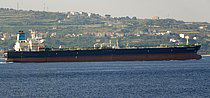

In [6]:
Image.open(image_path + train_csv['image'][3254])

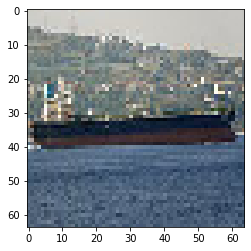

In [7]:
plt.imshow(X[3254])
plt.show()

In [8]:
y = train_csv['category'].values

In [19]:
list(set(y))

[1, 2, 3, 4, 5]

<AxesSubplot:ylabel='category'>

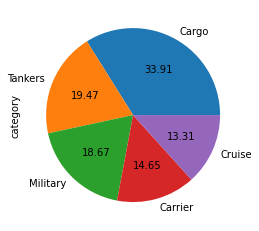

In [8]:
val = train_csv.loc[:, "category"].value_counts()
val = val.rename(index=mapping)
val.plot.pie(
    autopct='%.2f'
)

## Model Building: ResNet50

In [10]:
base_model = ResNet50(
    include_top=False, weights='imagenet', classes=5, input_shape=shape
)
layer = base_model.output
layer = GlobalAveragePooling2D()(layer)
layer = Flatten()(layer)
layer = Dense(units=len(mapping), activation='softmax')(layer)
model = Model(inputs = base_model.input, outputs = layer)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [11]:
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [12]:
for layer in base_model.layers:
    layer.trainable = False

## Performing the test train split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4689, 64, 64, 3), (1563, 64, 64, 3), (4689,), (1563,))

## Perform Image Augmentation

In [14]:
datagen = image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [15]:
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = datagen.flow(X_test, y_test, batch_size=batch_size)

In [16]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=20,
    validation_data=test_generator)

Epoch 1/20
195/195 [==============================] - 22s 62ms/step - loss: nan - accuracy: 0.0050 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/20
195/195 [==============================] - 11s 54ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/20
195/195 [==============================] - 11s 57ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 4/20
195/195 [==============================] - 11s 54ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 5/20
195/195 [==============================] - 10s 53ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 6/20
195/195 [==============================] - 11s 56ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 7/20
195/195 [==============================] - 11s 54ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_acc